In [4]:
# !pip install -q transformers
# !pip install -q accelerate
# !pip install -q bitsandbytes
# !pip install -q langchain
# !pip install -q sentence-transformers
# !pip install -q chromadb openpyxl
# !pip install -q ragatouille
# !pip install -q langchain_openai
# !pip install -q datasets
#!pip install PyPDF2

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)

In [15]:
import PyPDF2

def get_pdf_metadata(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        metadata = reader.metadata
        return metadata

pdf_path =r"/content/drive/MyDrive/chunking/ds (1).pdf"
metadata = get_pdf_metadata(pdf_path)

if metadata:
    for key, value in metadata.items():
        print(f"{key}: {value}")
else:
    print("No metadata found")


/Author: 
/Title: 
/Subject: 
/Creator: LaTeX with hyperref package
/Producer: pdfTeX-1.40.19
/Keywords: 
/CreationDate: D:20190814093040+02'00'
/ModDate: D:20190814093040+02'00'
/Trapped: /False
/PTEX.Fullbanner: This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) kpathsea version 6.3.0


In [25]:
import os
import PyPDF2
import pandas as pd
from datasets import Dataset

def get_pdf_metadata(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        metadata = reader.metadata
        return metadata

def get_pdf_text(pdf_path):
    text = ""
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        for page in reader.pages:
            text += page.extract_text()
    return text

def create_dataframe(pdf_dir):
    data = {
        'text': [],
        'source': []
    }

    for filename in os.listdir(pdf_dir):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(pdf_dir, filename)
            text = get_pdf_text(pdf_path)
            metadata = get_pdf_metadata(pdf_path)
            source = str(metadata)
            data['text'].append(text)
            data['source'].append(source)

    df = pd.DataFrame(data)
    return df

def create_arrow_dataset(df):
    # Convert pandas DataFrame to Hugging Face Dataset
    dataset = Dataset.from_pandas(df)
    return dataset

# Path to the directory containing your PDF files
pdf_dir = r'/content/drive/MyDrive/chunking/'
# Create the dataframe
df = create_dataframe(pdf_dir)

# Create the Arrow dataset
ds = create_arrow_dataset(df)

# Print the dataset
print(ds)


Dataset({
    features: ['text', 'source'],
    num_rows: 3
})


In [27]:
#Format the datasets into Langchain Document Schema
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]
print(len(RAW_KNOWLEDGE_BASE))
print(RAW_KNOWLEDGE_BASE[1].page_content)
print(RAW_KNOWLEDGE_BASE[1].metadata)

  0%|          | 0/3 [00:00<?, ?it/s]

3
Data	Science	from	Scratch
Joel	GrusData	Science	from	Scratch
by	
Joel	
Grus
Copyright	©	2015	O’Reilly	Media.	All	rights	reserved.
Printed	in	the	United	States	of	America.
Published	by	
O’Reilly	Media,	Inc.
,	1005	Gravenstein	Highway	North,	Sebastopol,	CA
95472.
O’Reilly	books	may	be	purchased	for	educational,	business,	or	sales	promotional	use.
Online	editions	are	also	available	for	most	titles	(
http://safaribooksonline.com
).	For	more
information,	contact	our	corporate/institutional	sales	department:	800-998-9938	or
corporate@oreilly.com
.
Editor:
	Marie	Beaugureau
Production	Editor:
	Melanie	Yarbrough
Copyeditor:
	Nan	Reinhardt
Proofreader:
	Eileen	Cohen
Indexer:
	Ellen	Troutman-Zaig
Interior	Designer:
	David	Futato
Cover	Designer:
	Karen	Montgomery
Illustrator:
	Rebecca	Demarest
April	2015:
	First	EditionRevision	History	for	the	First	Edition
2015-04-10:
	First	Release
See	
http://oreilly.com/catalog/errata.csp?isbn=9781491901427
	for	release	details.
The	O’Reilly	logo	is	a	regis

In [37]:
#Split the documents into chunks

from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class.
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # the maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # the number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [38]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# import tiktoken

# class RecursiveTokenTextSplitter(RecursiveCharacterTextSplitter):
#     def __init__(self, tokenizer_name='cl100k_base', chunk_size=1000, chunk_overlap=100, add_start_index=True, strip_whitespace=True, separators=None):
#         super().__init__(chunk_size=chunk_size, chunk_overlap=chunk_overlap, separators=separators)
#         self.tokenizer = tiktoken.get_encoding(tokenizer_name)
#         self.add_start_index = add_start_index
#         self.strip_whitespace = strip_whitespace

#     def split_text(self, text):
#         # Override split_text to use the custom _split_text
#         return self._split_text(text)

#     def _split_text(self, text):
#         # Tokenize the text
#         tokens = self.tokenizer.encode(text)
#         token_count = len(tokens)

#         # Initialize chunks
#         chunks = []
#         start = 0

#         while start < token_count:
#             end = min(start + self.chunk_size, token_count)
#             chunk_tokens = tokens[start:end]
#             chunk_text = self.tokenizer.decode(chunk_tokens)

#             if self.strip_whitespace:
#                 chunk_text = chunk_text.strip()

#             chunk_start_index = start if self.add_start_index else None
#             chunks.append((chunk_text, chunk_start_index))

#             start = end - self.chunk_overlap  # Move to the next chunk with overlap

#         return chunks

# # Example usage
# MARKDOWN_SEPARATORS = [
#     "\n#{1,6} ",
#     "```\n",
#     "\n\\*\\*\\*+\n",
#     "\n---+\n",
#     "\n___+\n",
#     "\n\n",
#     "\n",
#     " ",
#     "",
# ]

# text_splitter = RecursiveTokenTextSplitter(
#     chunk_size=1000,  # the maximum number of tokens in a chunk: we selected this value arbitrarily
#     chunk_overlap=100,  # the number of tokens to overlap between chunks
#     add_start_index=True,  # If `True`, includes chunk's start index in metadata
#     strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
#     separators=MARKDOWN_SEPARATORS,
# )

# # Assuming RAW_KNOWLEDGE_BASE is defined and contains documents
# docs_processed = []
# for doc in RAW_KNOWLEDGE_BASE:
#     docs_processed += text_splitter.split_text(doc)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model's maximum sequence length: 512


  0%|          | 0/943 [00:00<?, ?it/s]

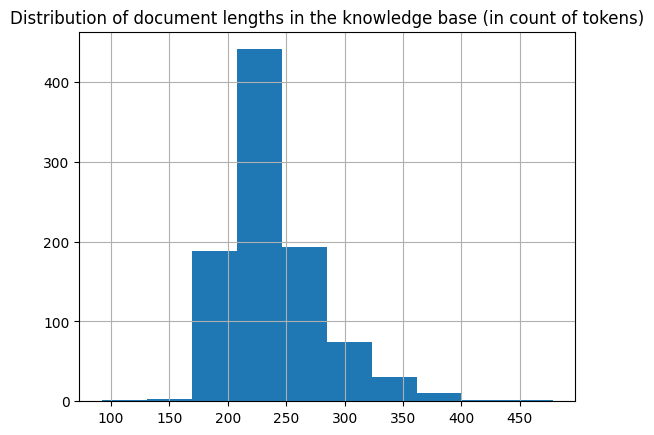

In [39]:
#Setup Embedding Model

from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter.
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distrubution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [41]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"
chunk_size = 512
#
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )
#
docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
  docs_processed += text_splitter.split_documents([doc])

print(len(docs_processed))

949


  0%|          | 0/949 [00:00<?, ?it/s]

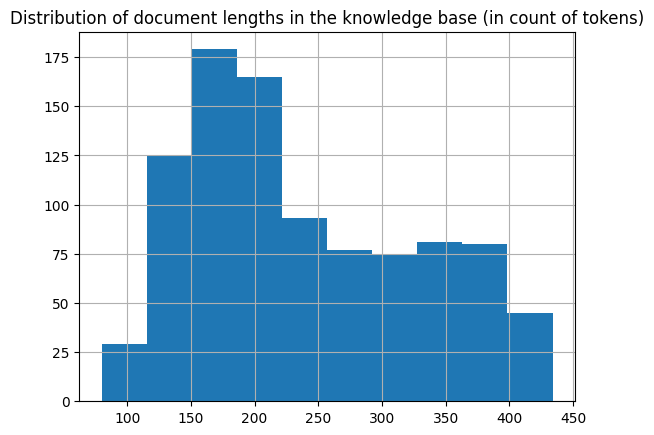

In [42]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [43]:
#Setup VectorStore

from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = Chroma.from_documents(docs_processed,
                                                  embedding_model,
                                                  persist_directory="/content/drive/MyDrive/chunking/CRAG",
                                                  collection_name="crag")
#
KNOWLEDGE_VECTOR_DATABASE.persist()
print(len(KNOWLEDGE_VECTOR_DATABASE.get()['documents']))

949


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


In [46]:
user_query = "what is Monge Problem?"
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[1].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[1].metadata)


Starting retrieval for user_query='what is Monge Problem?'...

==================================Top document==================================
to another. This happens when their weight vectors are not compatible, which is always the case when the
target measure has more points than the source measure. For instance, the right plot in Figure 1.3 shows
an (optimal) Monge map between and, but there is no Monge map from to.
6Monge problem (1.8) is extended to the setting of two arbitrary probability measures ( ;) on two spaces
(X;Y) as nding a map T:X!Y that minimizes
min
TZ
Xc(x;T(x))d(x) ;T]=
(1.9)
The constraint T]=means that Tpushes forward the mass of to, and makes use of the push-forward
operator (1.2).
1.3 Kantorovitch Problem
The assignment problem has several limitations in practical settings, also encountered when using the
Monge problem. Indeed, because the assignment problem is formulated as a permutation problem, it can only
be used to compare two points clou

In [ ]:
#Setup the LLM

In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from langchain.prompts import PromptTemplate
from langchain.llms import HuggingFacePipeline

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)
#

llm = HuggingFacePipeline(pipeline=READER_LLM)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]